## Krotov sandbox
_Will Kaufman, October 2020_

Most of this code comes from example code elsewhere...

[State-to-state transfer example](https://qucontrol.github.io/krotov/v1.2.0/notebooks/01_example_simple_state_to_state.html)

In [2]:
import qutip
import krotov
import numpy as np
import matplotlib.pyplot as plt

In [121]:
def hamiltonian(omega=1.0, a0=0.2):
    """Two-level-system Hamiltonian
    
    Arguments:
        omega (float): Energy difference of levels.
        a0 (float): Amplitude of driving field.
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()
    
    def guess_control(t, args):
        return  a0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func='blackman'
        )
    
    return [H0, [H1, guess_control]]

In [122]:
H = hamiltonian()

In [123]:
tlist = np.linspace(0, 5, 500)

In [124]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

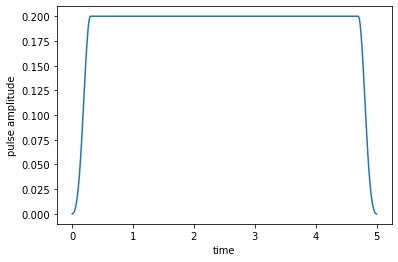

In [125]:
plot_pulse(H[1][1], tlist)

In [126]:
basis_states = [
    qutip.basis(2, 0), qutip.basis(2, 1)
]

In [127]:
U_targ = qutip.propagator(qutip.operators.sigmax(), np.pi/4)

In [128]:
# objectives = [
#     krotov.Objective(
#         initial_state=qutip.basis(2, 0), target=qutip.basis(2, 1), H=H
#     )
# ]

objectives = krotov.gate_objectives(
    basis_states=basis_states,
    gate=U_targ,
    H=H
)

In [129]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

In [130]:
pulse_options = {
    H[1][1]: dict(lambda_a=5, update_shape=S)
}

In [137]:
e_ops = [
    qutip.operators.sigmax(),
    qutip.operators.sigmay(),
    qutip.operators.sigmaz(),
]

e_labels = [
    r'$I_x$',
    r'$I_y$',
    r'$I_z$',
]

In [132]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=e_ops)

In [135]:
def plot_population(result, e_labels):
    fig, ax = plt.subplots()
    for i, label in enumerate(e_labels):
        ax.plot(result.times, result.expect[i], label=label)
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('expectation value')
    plt.show(fig)

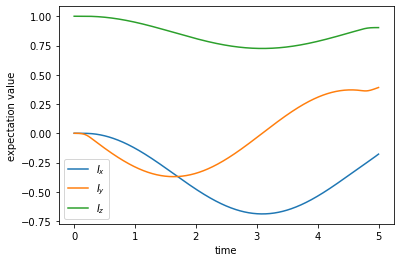

In [138]:
plot_population(guess_dynamics, e_labels)

In [85]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     6.96e-01    0.00e+00   6.96e-01        n/a        n/a     3
1     5.59e-01    1.19e-02   5.71e-01  -1.37e-01  -1.25e-01     6
2     4.03e-01    1.38e-02   4.17e-01  -1.56e-01  -1.42e-01     5
3     2.55e-01    1.34e-02   2.69e-01  -1.47e-01  -1.34e-01     6
4     1.43e-01    1.05e-02   1.54e-01  -1.12e-01  -1.02e-01     5
5     7.33e-02    6.71e-03   8.00e-02  -6.99e-02  -6.32e-02     5
6     3.56e-02    3.67e-03   3.93e-02  -3.77e-02  -3.40e-02     5
7     1.70e-02    1.83e-03   1.88e-02  -1.87e-02  -1.68e-02     5
8     8.09e-03    8.77e-04   8.96e-03  -8.89e-03  -8.02e-03     6
9     3.89e-03    4.15e-04   4.31e-03  -4.20e-03  -3.78e-03     6
10    1.90e-03    1.97e-04   2.10e-03  -1.99e-03  -1.79e-03     5
11    9.42e-04    9.45e-05   1.04e-03  -9.57e-04  -8.63e-04     5


In [139]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2020-10-06 17:23:56
- Number of objectives: 2
- Number of iterations: 11
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2020-10-06 17:25:04 (0:01:08)

In [140]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=e_ops)

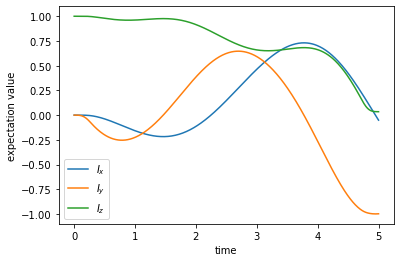

In [141]:
plot_population(opt_dynamics, e_labels)

In [153]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [155]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(8, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=e_ops
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = [f'{label} (guess)' for label in e_labels] # '0 (guess)', '1 (guess)'
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = [f'{label} (optimized)' for label in e_labels]
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None] * len(e_labels)
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        for i in range(len(e_labels)):
            ax_dyn.plot(
                dynamics.times,
                dynamics.expect[i],
                # TODO figure out below
                label=pop_labels[i],
                color=colors[i],
                ls=ls,
                alpha=alpha,
            )
#         ax_dyn.plot(
#             dynamics.times,
#             dynamics.expect[0],
#             label=pop_labels[0],
#             color='#1f77b4',  # default blue
#             ls=ls,
#             alpha=alpha,
#         )
#         ax_dyn.plot(
#             dynamics.times,
#             dynamics.expect[1],
#             label=pop_labels[1],
#             color='#ff7f0e',  # default orange
#             ls=ls,
#             alpha=alpha,
#         )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('expectation')
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    plt.show(fig)

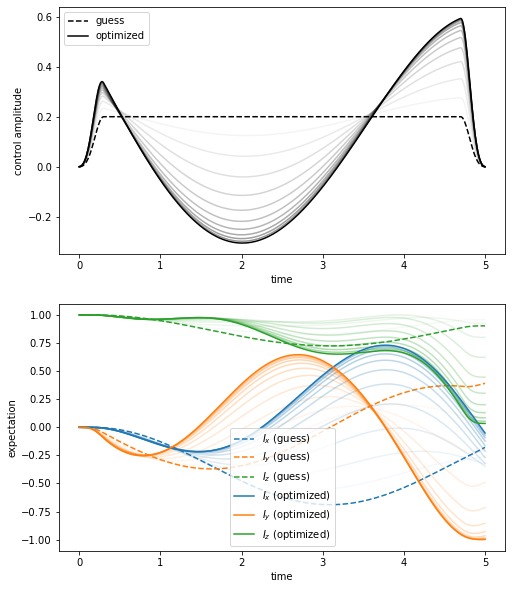

In [156]:
plot_iterations(opt_result)

##  Ensemble optimization

[Example](https://qucontrol.github.io/krotov/v1.2.0/notebooks/08_example_ensemble.html)

In [ ]:
# krotov.parallelization.set_parallelization(use_loky=True)
# from krotov.parallelization import parallel_map

In [29]:
# control fields
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=2.0, t_stop=5.0)


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse"""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=0.0, t_stop=3.0)


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse"""
    return 0.0

In [30]:
tlist = np.linspace(0, 5, 500)

In [33]:
def hamiltonian(E1=0.0, E2=10.0, E3=5.0, omega_P=9.5, omega_S=4.5):
    """Lambda-system Hamiltonian in the RWA"""

    # detunings
    delta_P = E1 + omega_P - E2
    delta_S = E3 + omega_S - E2

    H0 = qutip.Qobj([[delta_P, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, delta_S]])

    HP_re = -0.5 * qutip.Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * qutip.Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * qutip.Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * qutip.Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]

In [34]:
H = hamiltonian()

In [35]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))

In [36]:
def rwa_target_state(ket3, E2=10.0, omega_S=4.5, T=5):
    return np.exp(1j * (E2 - omega_S) * T) * ket3

In [37]:
psi_target = rwa_target_state(ket3)

In [38]:
objective = krotov.Objective(initial_state=ket1, target=psi_target, H=H)
objectives = [objective]
objectives

[Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁[3,3], u₁(t)], [H₂[3,3], u₂(t)], [H₃[3,3], u₃(t)], [H₄[3,3], u₄(t)]]]]

In [41]:
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)

In [43]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

In [45]:
def scale_control(H, *, mu):
    """Scale all control Hamiltonians by `mu`."""
    H_scaled = []
    for spec in H:
        if isinstance(spec, list):
            H_scaled.append([mu * spec[0], spec[1]])
        else:
            H_scaled.append(spec)
    return H_scaled

In [46]:
mu_vals = np.linspace(0.75, 1.25, 33)

In [47]:
def pop_error(obj, mu):
    res = obj.mesolve(tlist, H=scale_control(obj.H, mu=mu), e_ops=[proj3])
    return 1 - res.expect[0][-1]

In [48]:
# def _f(mu):
#     # parallel_map needs a global function
#     return pop_error(opt_result_unperturbed.optimized_objectives[0], mu=mu)


# pop_errors_norobust = parallel_map(_f, mu_vals)

In [49]:
def plot_robustness(mu_vals, pop_errors, pop_errors0=None):
    fig, ax = plt.subplots()
    ax.plot(mu_vals, pop_errors, label='1')
    if pop_errors0 is not None:
        ax.set_prop_cycle(None)  # reset colors
        if isinstance(pop_errors0, list):
            for (i, pop_errors_prev) in enumerate(pop_errors0):
                ax.plot(
                    mu_vals, pop_errors_prev, ls='dotted', label=("%d" % (-i))
                )
        else:
            ax.plot(mu_vals, pop_errors0, ls='dotted', label='0')
    ax.set_xlabel("relative coupling strength")
    ax.set_ylabel(r"$1 - \vert \langle \Psi \vert 3 \rangle \vert^2$")
    ax.axvspan(0.9, 1.1, alpha=0.25, color='red')
    ax.set_yscale('log')
    if pop_errors0 is not None:
        ax.legend()
    plt.show(fig)

In [51]:
ensemble_mu = [0.9, 0.95, 1.0, 1.05, 1.1]

In [52]:
ham_ensemble = [scale_control(objective.H, mu=mu) for mu in ensemble_mu]

In [53]:
ensemble_objectives = krotov.objectives.ensemble_objectives(
    objectives, ham_ensemble, keep_original_objectives=False,
)
ensemble_objectives

[Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₅[3,3], u₁(t)], [H₆[3,3], u₂(t)], [H₇[3,3], u₃(t)], [H₈[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₉[3,3], u₁(t)], [H₁₀[3,3], u₂(t)], [H₁₁[3,3], u₃(t)], [H₁₂[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁₃[3,3], u₁(t)], [H₁₄[3,3], u₂(t)], [H₁₅[3,3], u₃(t)], [H₁₆[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁₇[3,3], u₁(t)], [H₁₈[3,3], u₂(t)], [H₁₉[3,3], u₃(t)], [H₂₀[3,3], u₄(t)]]],
 Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₂₁[3,3], u₁(t)], [H₂₂[3,3], u₂(t)], [H₂₃[3,3], u₃(t)], [H₂₄[3,3], u₄(t)]]]]

In [54]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(t, 0.0, 5, 0.3, func='sinsq')


lam = 0.5

pulse_options = {
    H[1][1]: dict(lambda_a=lam, update_shape=S),
    H[2][1]: dict(lambda_a=lam, update_shape=S),
    H[3][1]: dict(lambda_a=lam, update_shape=S),
    H[4][1]: dict(lambda_a=lam, update_shape=S),
}

In [55]:
def print_J_T_per_target(**kwargs):
    iteration = kwargs['iteration']
    N = len(ensemble_mu)
    if iteration == 0:
        print(
            "iteration "
            + "%11s " % "J_T(avg)"
            + " ".join([("J_T(μ=%.2f)" % μ) for μ in ensemble_mu])
        )
    J_T_vals = 1 - kwargs['tau_vals'].real
    J_T = np.sum(J_T_vals) / N
    print(
        ("%9d " % iteration)
        + ("%11.2e " % J_T)
        + " ".join([("%11.2e" % v) for v in J_T_vals])
    )

In [56]:
log_fh = open("ensemble_opt.log", "w", encoding="utf-8")

In [57]:
opt_result = krotov.optimize_pulses(
    ensemble_objectives,
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.chain(
        print_J_T_per_target,
        krotov.info_hooks.print_table(
            J_T=krotov.functionals.J_T_re, out=log_fh
        ),
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    iter_stop=12,
)

iteration    J_T(avg) J_T(μ=0.90) J_T(μ=0.95) J_T(μ=1.00) J_T(μ=1.05) J_T(μ=1.10)
        0    1.01e+00    1.01e+00    1.01e+00    1.01e+00    1.01e+00    1.01e+00
        1    6.79e-01    6.94e-01    6.83e-01    6.75e-01    6.71e-01    6.71e-01
        2    4.14e-01    4.40e-01    4.20e-01    4.07e-01    4.00e-01    4.00e-01
        3    2.36e-01    2.68e-01    2.43e-01    2.27e-01    2.20e-01    2.23e-01
        4    1.32e-01    1.63e-01    1.37e-01    1.21e-01    1.16e-01    1.22e-01
        5    7.46e-02    1.04e-01    7.78e-02    6.29e-02    5.98e-02    6.86e-02
        6    4.46e-02    7.13e-02    4.58e-02    3.23e-02    3.12e-02    4.26e-02
        7    2.92e-02    5.32e-02    2.88e-02    1.66e-02    1.72e-02    3.04e-02
        8    2.14e-02    4.32e-02    1.96e-02    8.59e-03    1.04e-02    2.50e-02
        9    1.73e-02    3.74e-02    1.46e-02    4.48e-03    7.25e-03    2.28e-02
       10    1.52e-02    3.41e-02    1.19e-02    2.37e-03    5.83e-03    2.21e-02
       11    1.4

In [58]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2020-10-06 16:56:14
- Number of objectives: 5
- Number of iterations: 12
- Reason for termination: Reached 12 iterations
- Ended at 2020-10-06 17:00:35 (0:04:21)

In [60]:
log_fh.close()

pump pulse amplitude and phase:


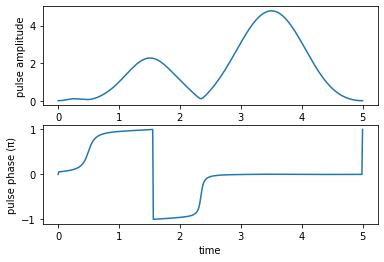

Stokes pulse amplitude and phase:


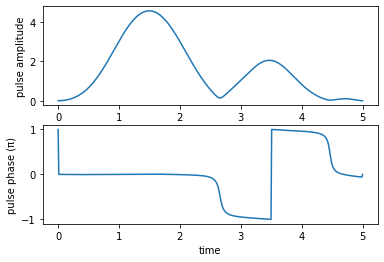

In [61]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary, tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [
        np.sqrt(x * x + y * y) for x, y in zip(pulse_real, pulse_imaginary)
    ]
    phases = [
        np.arctan2(y, x) / np.pi for x, y in zip(pulse_real, pulse_imaginary)
    ]
    ax1.plot(tlist, amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist, phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')
    plt.show()


print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist
)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist
)

In [62]:
opt_robust_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj1, proj2, proj3]
)

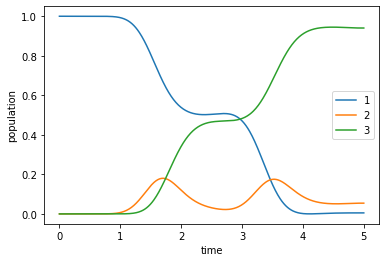

In [63]:
plot_population(opt_robust_dynamics)

In [68]:
# def _f(mu):
#     return pop_error(opt_result.optimized_objectives[0], mu=mu)


# pop_errors_robust = parallel_map(_f, mu_vals)

pop_errors_robust = [
    pop_error(opt_result.optimized_objectives[0], mu=mu) for mu in mu_vals
]

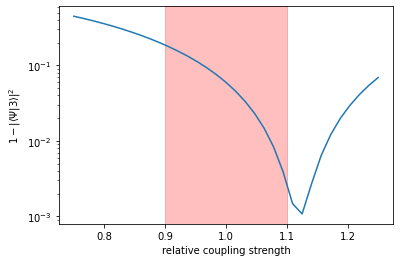

In [69]:
plot_robustness(
    mu_vals,
    pop_errors_robust,
)